<h1>Template for multilevel analysis</h1>

In [1]:
library(lme4)
library(lmerTest)
library(nlme)
library(ggplot2)
library(grid)
library(gridExtra)
library(lattice)
library(plyr)
library(MASS)
library(stats4)
library(dplyr)

Loading required package: Matrix

Attaching package: ‘lmerTest’

The following object is masked from ‘package:lme4’:

    lmer

The following object is masked from ‘package:stats’:

    step


Attaching package: ‘nlme’

The following object is masked from ‘package:lme4’:

    lmList


Attaching package: ‘dplyr’

The following object is masked from ‘package:MASS’:

    select

The following objects are masked from ‘package:plyr’:

    arrange, count, desc, failwith, id, mutate, rename, summarise,
    summarize

The following object is masked from ‘package:gridExtra’:

    combine

The following object is masked from ‘package:nlme’:

    collapse

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



<h2>Load data</h2>

In [2]:
rm(list = ls())
mydata <- read.table("data.csv", header=TRUE, sep=",")

# sessions: ebld7meg, brtqjddt, 6zu2rqqa, eziaa6hq

In [101]:
# does someone need to be excluded? if so, then do this
#mydata <- subset(mydata, code != "xxxxxx")

# make sure there are NAs where the decision times are too slow (thousands of seconds)
#mydata$dt <- ifelse(mydata$dt > 60, "NA", mydata$dt)

<h2>Summary statistics</h2>

In [17]:
# the plyr package has really useful summarising functions
ddply(mydata, c("treatment"), summarise, 
      N = length(choice)/216,
      'mean DT' = mean(dt, na.rm=T),
      'sd DT' = sd(dt, na.rm=T),
      'mean dec. mode' = mean(decmode),
      'mean accuracy' = mean(accuracy))

treatment,N,mean DT,sd DT,mean dec. mode,mean accuracy
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
A,36,2.938477,5.320870,3.666667,0.6579218
E,36,3.037160,4.251024,4.361111,0.6464884


<h2>Correlation matrix for psychometric measurements</h2>

In [4]:
cordf <- mydata %>% select(ref,int,nfc,fi,bnt)
cor(cordf)

,ref,int,nfc,fi,bnt
ref,1.0000000,-0.88858377,0.1150721514,-0.18074574,0.5277104515
int,-0.8885838,1.00000000,-0.0361085404,0.26342536,-0.3554411973
nfc,0.1150722,-0.03610854,1.0000000000,-0.06474535,0.0007635697
fi,-0.1807457,0.26342536,-0.0647453490,1.00000000,-0.0978282379
bnt,0.5277105,-0.35544120,0.0007635697,-0.09782824,1.0000000000


<h2>Accuracy correlates with reflectiveness when controlling interations between ref and int</h2>

In [18]:
summary(lm(accuracy ~ scale(ref)*scale(int), subset(mydata, round==1)))
summary(lm(accuracy ~ scale(nfc)*scale(fi), subset(mydata, round==1)))


Call:
lm(formula = accuracy ~ scale(ref) * scale(int), data = subset(mydata, 
    round == 1))

Residuals:
     Min       1Q   Median       3Q      Max 
-0.28922 -0.10573  0.01186  0.10184  0.26822 

Coefficients:
                      Estimate Std. Error t value Pr(>|t|)    
(Intercept)            0.63698    0.02277  27.976   <2e-16 ***
scale(ref)             0.08404    0.03653   2.301   0.0245 *  
scale(int)             0.03718    0.03596   1.034   0.3048    
scale(ref):scale(int) -0.01737    0.01917  -0.906   0.3681    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.1304 on 68 degrees of freedom
Multiple R-squared:  0.1798,	Adjusted R-squared:  0.1437 
F-statistic:  4.97 on 3 and 68 DF,  p-value: 0.003539



Call:
lm(formula = accuracy ~ scale(nfc) * scale(fi), data = subset(mydata, 
    round == 1))

Residuals:
    Min      1Q  Median      3Q     Max 
-0.3055 -0.1145  0.0205  0.1075  0.2348 

Coefficients:
                      Estimate Std. Error t value Pr(>|t|)    
(Intercept)           0.652368   0.016881  38.645   <2e-16 ***
scale(nfc)           -0.006592   0.017061  -0.386    0.700    
scale(fi)             0.016344   0.017236   0.948    0.346    
scale(nfc):scale(fi)  0.002553   0.020188   0.126    0.900    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.1428 on 68 degrees of freedom
Multiple R-squared:  0.01611,	Adjusted R-squared:  -0.02729 
F-statistic: 0.3713 on 3 and 68 DF,  p-value: 0.774


<h2>Decision mode does not differ between treatments</h2>

In [19]:
summary(lm(decmode ~ treatment, subset(mydata, round==1)))


Call:
lm(formula = decmode ~ treatment, data = subset(mydata, round == 
    1))

Residuals:
    Min      1Q  Median      3Q     Max 
-2.6667 -1.4375 -0.0139  1.3333  3.3333 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)   3.6667     0.2819  13.005   <2e-16 ***
treatmentE    0.6944     0.3987   1.742    0.086 .  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 1.692 on 70 degrees of freedom
Multiple R-squared:  0.04154,	Adjusted R-squared:  0.02784 
F-statistic: 3.034 on 1 and 70 DF,  p-value: 0.08595


<h2>Decision mode correlates only with FI</h2>
<p>For NFC and FI we must look into interaction effects</p>

In [20]:
summary(lm(decmode ~ scale(ref)+scale(int), subset(mydata, round==1)))
summary(lm(decmode ~ scale(nfc)*scale(fi), subset(mydata, round==1)))
summary(lm(decmode ~ scale(bnt), subset(mydata, round==1)))


Call:
lm(formula = decmode ~ scale(ref) + scale(int), data = subset(mydata, 
    round == 1))

Residuals:
     Min       1Q   Median       3Q      Max 
-3.03689 -1.27980 -0.02978  1.02797  3.02708 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept)  4.013889   0.205074  19.573   <2e-16 ***
scale(ref)   0.007562   0.450200   0.017    0.987    
scale(int)  -0.020898   0.450200  -0.046    0.963    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 1.74 on 69 degrees of freedom
Multiple R-squared:  0.0002632,	Adjusted R-squared:  -0.02871 
F-statistic: 0.009083 on 2 and 69 DF,  p-value: 0.991



Call:
lm(formula = decmode ~ scale(nfc) * scale(fi), data = subset(mydata, 
    round == 1))

Residuals:
    Min      1Q  Median      3Q     Max 
-3.1420 -1.3533  0.0448  1.4616  3.4666 

Coefficients:
                     Estimate Std. Error t value Pr(>|t|)    
(Intercept)            4.0211     0.2004  20.070   <2e-16 ***
scale(nfc)             0.1601     0.2025   0.790   0.4320    
scale(fi)              0.4257     0.2046   2.081   0.0412 *  
scale(nfc):scale(fi)   0.1136     0.2396   0.474   0.6368    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 1.695 on 68 degrees of freedom
Multiple R-squared:  0.06501,	Adjusted R-squared:  0.02377 
F-statistic: 1.576 on 3 and 68 DF,  p-value: 0.2032



Call:
lm(formula = decmode ~ scale(bnt), data = subset(mydata, round == 
    1))

Residuals:
     Min       1Q   Median       3Q      Max 
-2.99956 -1.39696 -0.07326  1.29524  3.14784 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)   4.0139     0.2026  19.809   <2e-16 ***
scale(bnt)   -0.1699     0.2041  -0.833    0.408    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 1.719 on 70 degrees of freedom
Multiple R-squared:  0.009806,	Adjusted R-squared:  -0.00434 
F-statistic: 0.6932 on 1 and 70 DF,  p-value: 0.4079


<h2>Decision mode vs. psychometrics scatter plots</h2>

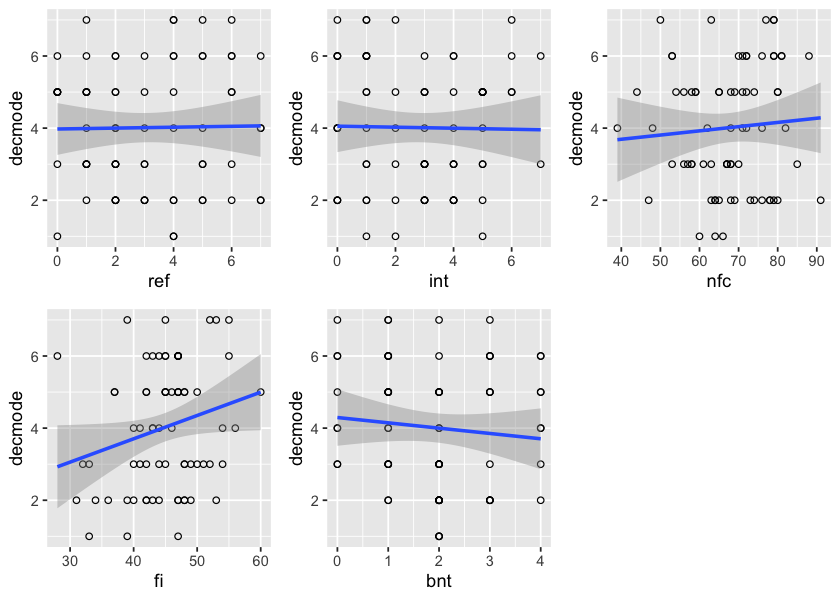

In [21]:
options(repr.plot.width=7, repr.plot.height=5)


gpl1 <- ggplot(subset(mydata, round==1), aes(x=ref, y=decmode)) + geom_point(shape=1) + geom_smooth(method=lm)
gpl2 <- ggplot(subset(mydata, round==1), aes(x=int, y=decmode)) + geom_point(shape=1) + geom_smooth(method=lm)
gpl3 <- ggplot(subset(mydata, round==1), aes(x=nfc, y=decmode)) + geom_point(shape=1) + geom_smooth(method=lm)
gpl4 <- ggplot(subset(mydata, round==1), aes(x=fi,  y=decmode)) + geom_point(shape=1) + geom_smooth(method=lm)
gpl5 <- ggplot(subset(mydata, round==1), aes(x=bnt, y=decmode)) + geom_point(shape=1) + geom_smooth(method=lm)


grid.arrange(gpl1, gpl2, gpl3, gpl4, gpl5, nrow = 2)


<h2>DT ecdf</h2>

Warning message:
“Removed 791 rows containing non-finite values (stat_ecdf).”

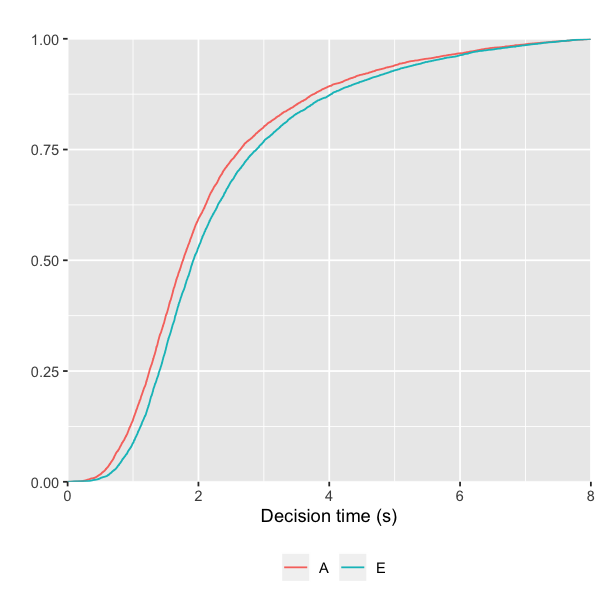

In [48]:
options(repr.plot.width=5, repr.plot.height=5)


ecdf <- ggplot(subset(mydata, (treatment=="A" | treatment=="E")), aes(dt, colour=treatment)) + 
        stat_ecdf(geom = "step") + 
        labs(title = "", y = "", x = "Decision time (s)") +
        scale_x_continuous(expand= c(0, 0), limits = c(0, 8)) +
        scale_y_continuous(expand = c(0, 0)) + 
        theme(legend.position="bottom", legend.title=element_blank())

ecdf

<h2>DT distributions differ at the aggregate level</h2>

In [23]:
ks.test(mydata$dt[mydata$treatment=="A"], mydata$dt[mydata$treatment=="E"], alternative="greater")

Warning message in ks.test(mydata$dt[mydata$treatment == "A"], mydata$dt[mydata$treatment == :
“p-value will be approximate in the presence of ties”


	Two-sample Kolmogorov-Smirnov test

data:  mydata$dt[mydata$treatment == "A"] and mydata$dt[mydata$treatment == "E"]
D^+ = 0.075508, p-value < 2.2e-16
alternative hypothesis: the CDF of x lies above that of y


<h2>Simple linear regression with averaged DTs: DT is decreasing in decision mode</h2>
<p>Determine the average DT for each participant, add this as a column in the data frame, and use a linear model without random effects</p>

In [24]:
aggrdata <- mydata %>% group_by(code) %>% summarise(meandt = mean(dt, na.rm=T))
mydata$meandt <- rep(aggrdata$meandt, each=216)

In [25]:
summary(lm(meandt ~ decmode, mydata))


Call:
lm(formula = meandt ~ decmode, data = mydata)

Residuals:
    Min      1Q  Median      3Q     Max 
-2.1344 -0.8222 -0.2512  0.5170  4.4861 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept)  3.077356   0.026228 117.330  < 2e-16 ***
decmode     -0.022346   0.006015  -3.715 0.000204 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 1.278 on 15550 degrees of freedom
Multiple R-squared:  0.0008868,	Adjusted R-squared:  0.0008226 
F-statistic:  13.8 on 1 and 15550 DF,  p-value: 0.0002038


<h2>GLMM with subject random effects: DT is not dependent on decision mode</h2>
<p>This uses a GLMM and recognises different variances in DTs over the subjects. The distribution family we use is Gamma distribution in accordance with Lo & Andrews (2015).</p>

In [26]:
summary(glmer(dt ~ decmode + (1|code), mydata, family = Gamma(link = "identity")))
summary(glmer(dt ~ scale(decmode)*treatment + (1|code), mydata, family = Gamma(link = "identity")))

Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: Gamma  ( identity )
Formula: dt ~ decmode + (1 | code)
   Data: mydata

     AIC      BIC   logLik deviance df.resid 
 59080.9  59111.6 -29536.5  59072.9    15544 

Scaled residuals: 
   Min     1Q Median     3Q    Max 
-0.726 -0.350 -0.191  0.064 48.594 

Random effects:
 Groups   Name        Variance Std.Dev.
 code     (Intercept) 3.040    1.744   
 Residual             1.895    1.377   
Number of obs: 15548, groups:  code, 72

Fixed effects:
            Estimate Std. Error t value Pr(>|z|)    
(Intercept)  2.47883    0.38190   6.491 8.54e-11 ***
decmode      0.12894    0.08761   1.472    0.141    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
        (Intr)
decmode -0.920

Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: Gamma  ( identity )
Formula: dt ~ scale(decmode) * treatment + (1 | code)
   Data: mydata

     AIC      BIC   logLik deviance df.resid 
 59083.3  59129.2 -29535.6  59071.3    15542 

Scaled residuals: 
   Min     1Q Median     3Q    Max 
-0.726 -0.350 -0.191  0.064 48.700 

Random effects:
 Groups   Name        Variance Std.Dev.
 code     (Intercept) 2.972    1.724   
 Residual             1.897    1.377   
Number of obs: 15548, groups:  code, 72

Fixed effects:
                           Estimate Std. Error t value Pr(>|z|)    
(Intercept)                3.033267   0.213118  14.233   <2e-16 ***
scale(decmode)             0.419187   0.215440   1.946   0.0517 .  
treatmentE                 0.006106   0.301209   0.020   0.9838    
scale(decmode):treatmentE -0.392462   0.301459  -1.302   0.1930    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed 

<h2>DT is decreasing over time as expected</h2>

In [69]:
# summary(glmer(dt ~ round + (1|code), subset(mydata, round>200), family = Gamma(link = "identity")))
mydata$logdt <- log(1+mydata$dt)
summary(lmer(logdt ~ round + (1|code), mydata))

Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: logdt ~ round + (1 | code)
   Data: mydata

REML criterion at convergence: 19927.4

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-3.8002 -0.6048 -0.1956  0.3499  9.6846 

Random effects:
 Groups   Name        Variance Std.Dev.
 code     (Intercept) 0.0577   0.2402  
 Residual             0.2067   0.4546  
Number of obs: 15548, groups:  code, 72

Fixed effects:
              Estimate Std. Error         df t value Pr(>|t|)    
(Intercept)  1.341e+00  2.924e-02  7.819e+01   45.85   <2e-16 ***
round       -1.412e-03  5.847e-05  1.548e+04  -24.14   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
      (Intr)
round -0.217

<h2>Choice probabilities are not affected by the psychometric variables nor decision mode</h2>

In [27]:
summary(glmer(choice ~ scale(ref)*scale(int) + (1|code), mydata, family=binomial(link = "logit")))
summary(glmer(choice ~ scale(nfc)*scale(fi) + (1|code), mydata, family=binomial(link = "logit")))
summary(glmer(choice ~ scale(bnt) + (1|code), mydata, family=binomial(link = "logit")))

Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: choice ~ scale(ref) * scale(int) + (1 | code)
   Data: mydata

     AIC      BIC   logLik deviance df.resid 
 19848.0  19886.3  -9919.0  19838.0    15547 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-2.1793 -0.9455 -0.4092  0.9238  2.9539 

Random effects:
 Groups Name        Variance Std.Dev.
 code   (Intercept) 0.6013   0.7754  
Number of obs: 15552, groups:  code, 72

Fixed effects:
                      Estimate Std. Error z value Pr(>|z|)
(Intercept)           -0.12488    0.13782  -0.906    0.365
scale(ref)             0.24849    0.22044   1.127    0.260
scale(int)             0.19751    0.21704   0.910    0.363
scale(ref):scale(int)  0.01359    0.11443   0.119    0.905

Correlation of Fixed Effects:
            (Intr) scl(r) scl(n)
scale(ref)  0.282               
scale(int)  0.255  0.903        
scl(rf):s() 0.738  0.383  0.347 

Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: choice ~ scale(nfc) * scale(fi) + (1 | code)
   Data: mydata

     AIC      BIC   logLik deviance df.resid 
 19848.4  19886.7  -9919.2  19838.4    15547 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-2.1738 -0.9460 -0.4067  0.9236  2.9364 

Random effects:
 Groups Name        Variance Std.Dev.
 code   (Intercept) 0.6045   0.7775  
Number of obs: 15552, groups:  code, 72

Fixed effects:
                     Estimate Std. Error z value Pr(>|z|)
(Intercept)          -0.13422    0.09356  -1.435    0.151
scale(nfc)           -0.03735    0.09384  -0.398    0.691
scale(fi)             0.08304    0.09496   0.874    0.382
scale(nfc):scale(fi)  0.04297    0.11035   0.389    0.697

Correlation of Fixed Effects:
            (Intr) scl(n) scl(f)
scale(nfc)  0.005               
scale(fi)   0.012  0.080        
scl(nfc):() 0.076  0.095  0.171 

Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: choice ~ scale(bnt) + (1 | code)
   Data: mydata

     AIC      BIC   logLik deviance df.resid 
 19845.2  19868.2  -9919.6  19839.2    15549 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-2.1750 -0.9450 -0.4081  0.9240  2.9551 

Random effects:
 Groups Name        Variance Std.Dev.
 code   (Intercept) 0.6118   0.7822  
Number of obs: 15552, groups:  code, 72

Fixed effects:
            Estimate Std. Error z value Pr(>|z|)
(Intercept) -0.13702    0.09388  -1.460    0.144
scale(bnt)   0.04583    0.09399   0.488    0.626

Correlation of Fixed Effects:
           (Intr)
scale(bnt) 0.001 

<h2>DTs are longer in lottery choices but only in treatment E</h2>

In [28]:
summary(glmer(dt ~ choice*treatment + (1|code), family = Gamma(link = "identity"), mydata))

Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: Gamma  ( identity )
Formula: dt ~ choice * treatment + (1 | code)
   Data: mydata

     AIC      BIC   logLik deviance df.resid 
 59065.5  59111.4 -29526.7  59053.5    15542 

Scaled residuals: 
   Min     1Q Median     3Q    Max 
-0.727 -0.350 -0.189  0.063 48.456 

Random effects:
 Groups   Name        Variance Std.Dev.
 code     (Intercept) 3.115    1.765   
 Residual             1.889    1.375   
Number of obs: 15548, groups:  code, 72

Fixed effects:
                  Estimate Std. Error t value Pr(>|z|)    
(Intercept)        2.93327    0.21478  13.657  < 2e-16 ***
choice             0.02964    0.03735   0.794  0.42740    
treatmentE         0.02869    0.30371   0.094  0.92473    
choice:treatmentE  0.15056    0.05454   2.761  0.00577 ** 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
            (Intr) choice trtmnE
choice     